In [1]:
## 원리
## https://velog.io/@cha-suyeon/SRCNN을-이용한-Super-Resolution-구현-6zphnhj8
## 코드
## https://github.com/HeaseoChung/FSRCNN-PyTorch/blob/master/models.py
## 다른 코드
## https://github.com/Nhat-Thanh/FSRCNN-TF/blob/main/neuralnet.py
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
# 이미지 한개 불러오기(총 2개)
bicubic_folder = "./hr2_down/"
hr_folder = "./hr2/"

hr = Image.open(hr_folder+"frame1655.png")
bicubic_sr = Image.open(bicubic_folder+"frame1655.png")

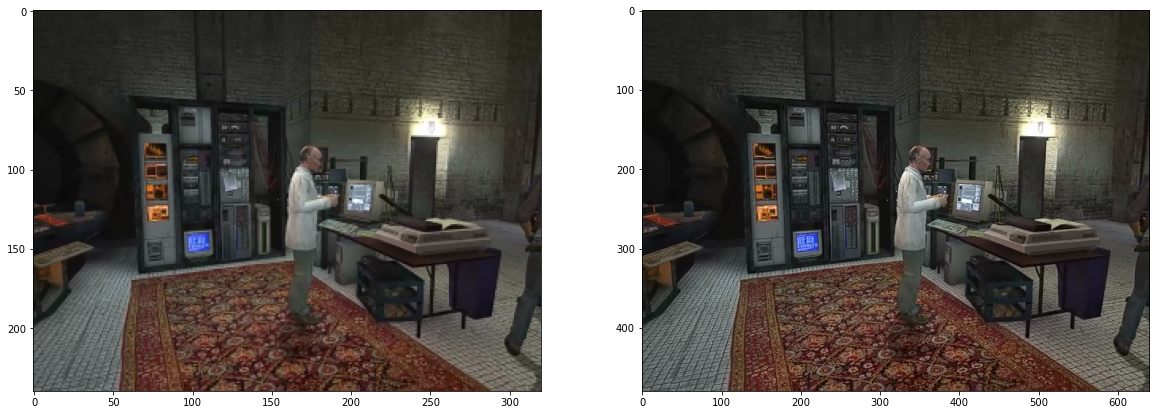

In [3]:
## 이미지 비교
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(bicubic_sr)

plt.subplot(1,2,2)
plt.imshow(hr)

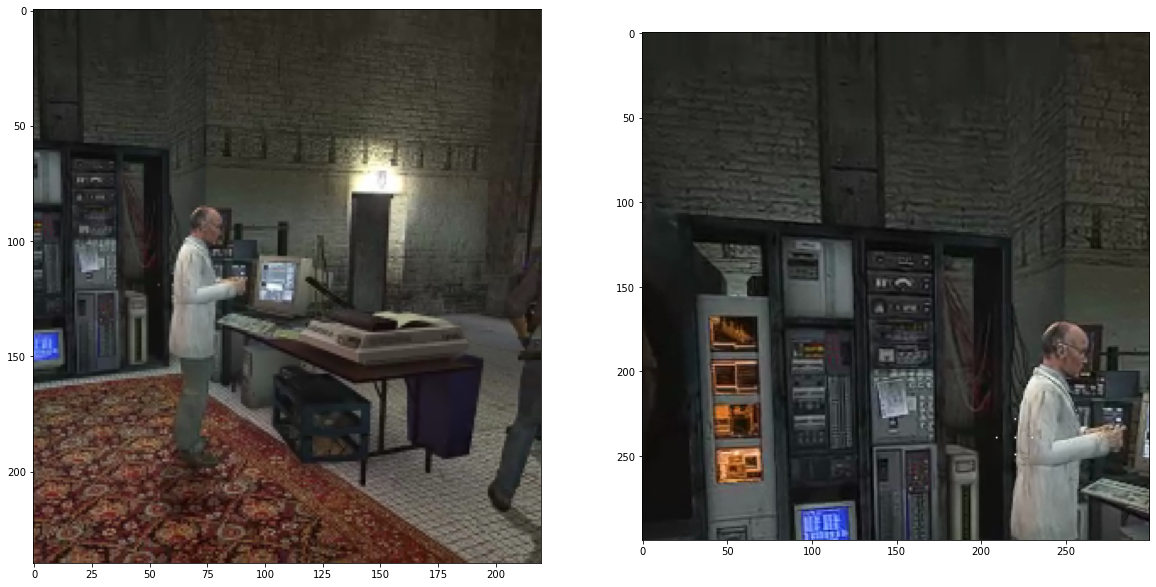

In [4]:
## srcnn 기준 
##crop해서 어느정도 화질이 구려지는지 확인해보자
a = np.array(bicubic_sr)
c = np.array(hr)

def crop(img, z, x=300,y=300):
    return img[z[0]:(z[0]+x), z[1]:(z[1]+y), :]

z = (0,100)
bicubic_crop = crop(a,z)
hr_crop = crop(c,z)

## 이미지 비교
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(bicubic_crop)

plt.subplot(1,2,2)
plt.imshow(hr_crop)

In [2]:
## hr, bicubic_sr 을 넘파이배열로 읽어서 리스트에 각각 저장

# 불러오기1
import natsort

# low 리스트 불러오기
bicubic_folder = "./hr2_down/"
hr_folder = "./hr2/"

l = os.listdir(bicubic_folder)
if ".DS_Store" in l:
    l.remove(".DS_Store")
    
# high 리스트 불러오기
h = os.listdir(hr_folder)
if ".DS_Store" in h:
    h.remove(".DS_Store")
    
B_SR = []
HR = []

l = natsort.natsorted(l)
h = natsort.natsorted(h)

for x in l[3000:4000]: # 양이 많아서 일단 1000개로 줄임
    img = cv2.imread(bicubic_folder+x)
    q = np.asarray(img,dtype = np.float32)/255.
    B_SR.append(q)

for x in h[3000:4000]: # 양이 많아서 일단 1000개로 줄임
    img = cv2.imread(hr_folder+x)
    w = np.asarray(img,dtype = np.float32)/255.
    HR.append(w)

In [3]:
# 1/255화

#B_SR = tf.cast(B_SR, tf.float32) /255.
#HR = tf.cast(HR, tf.float32) /255.

## 커널 오류는 메모리 문제였던걸로 판명
## 변수를 최소화 하고 오래걸리고 메모리를 많이 차지하는 코드를 위 처럼바꿈

Metal device set to: Apple M1


2022-04-08 13:46:03.100291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-08 13:46:03.100513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [38]:
# 넘파이배열로 각각 저장하자(또 오류나면 곤란)
# 전체 이미지 해보니깐 각각 28기가 정도로 저장되서 곤란
#np.save('B_SR', B_SR)
#np.save('HR', HR)

In [3]:
#print(HR.shape)
#print(B_SR.shape)

In [4]:
## 개수 세기
print(len(B_SR),len(HR))

993 993


In [5]:
## train, valid 만들기
# 전체 이미지 수 3993개 중 1000개 중 800:200 으로 분리

# train
B_SR_t = B_SR[:800]
HR_t = HR[:800]

# validation
B_SR_v = B_SR[800:]
HR_v = HR[800:]

In [6]:
## 인풋에 들어갈 train,valid 데이터셋을 BatchDataset으로 바꿔보자
train = tf.data.Dataset.from_tensor_slices((B_SR_t, HR_t))
valid = tf.data.Dataset.from_tensor_slices((B_SR_v, HR_v))

Metal device set to: Apple M1


2022-04-13 16:16:26.223972: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-13 16:16:26.224051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# prefetch화
train2 = train.prefetch(1)
valid2 = valid.prefetch(1)

In [8]:
# prefetch화된 훈련, 검증데이터 형태 확인
print(train2)
print(valid2)

<PrefetchDataset shapes: ((240, 320, 3), (480, 640, 3)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((240, 320, 3), (480, 640, 3)), types: (tf.float32, tf.float32)>


In [9]:
# shuffle, batchsize 지정
# batch_size 만큼 이미지들을 한꺼번에 학습
# 버퍼사이즈만큼 셔플링(학습데이터보다 같거나 커야 전부 잘 섞여요)
train3 = train2.shuffle(buffer_size=1000).batch(10)
valid3 = valid2.batch(10)

In [10]:
print(train3)
print(valid3)

<BatchDataset shapes: ((None, 240, 320, 3), (None, 480, 640, 3)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 240, 320, 3), (None, 480, 640, 3)), types: (tf.float32, tf.float32)>


In [ ]:
'''## 텐서 저장 예시
a = tf.constant([1,2,3,4,5] , dtype = tf.int32)
b = tf.constant([53.44569] , dtype= tf.float32)
c = tf.constant(0)
# if u wish to write all these tensors on each line ,
# then create a single string out of these.
one_string = tf.strings.format("{}\n{}\n{}\n", (a,b,c))
# {} is a placeholder for each element ina string and thus you would need n PH for n tensors.
# send this string to write_file fn
tf.io.write_file(filename, one_string)'''

In [23]:
## 모델 파라미터 설정
d = 56 #채널 개수1
s = 12 #채널 개수2
n = 4 #비선형 맵핑 횟수

scale = 2 # 이게 사실상 4배임

In [24]:
## srcnn 구현
from tensorflow.keras import layers

fsrcnn = tf.keras.Sequential()

fsrcnn.add(layers.Input(shape=(None, None, 3)))
fsrcnn.add(layers.Conv2D(d, 5, padding="same"))
fsrcnn.add(layers.PReLU(shared_axes=[1, 2]))

fsrcnn.add(layers.Conv2D(s, kernel_size=1, padding="same"))
fsrcnn.add(layers.PReLU(shared_axes=[1, 2]))

for x in range(n):
    fsrcnn.add(layers.Conv2D(s, kernel_size=3, padding="same"))
    fsrcnn.add(layers.PReLU(shared_axes=[1, 2]))

fsrcnn.add(layers.Conv2D(d, kernel_size=1))
fsrcnn.add(layers.PReLU(shared_axes=[1, 2]))

fsrcnn.add(layers.Conv2DTranspose(3, kernel_size=9, strides=scale, padding="same"))

fsrcnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, None, None, 56)    4256      
                                                                 
 p_re_lu_7 (PReLU)           (None, None, None, 56)    56        
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 12)    684       
                                                                 
 p_re_lu_8 (PReLU)           (None, None, None, 12)    12        
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 12)    1308      
                                                                 
 p_re_lu_9 (PReLU)           (None, None, None, 12)    12        
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 12)   

In [25]:
# 컴파일

fsrcnn.compile(optimizer="adam",loss="mse")
#전이학습시에는 h5모델 내부에 이미 컴파일되어있으므로 생략가능

In [12]:
# early stop
es = EarlyStopping(monitor='val_loss',verbose=1, patience=3)

# model early save
mc = ModelCheckpoint('./model/fsrcnn_1_hf4.h5', monitor='val_loss', save_best_only=True)

In [13]:
# 훈련
model = fsrcnn.fit(train3,validation_data = valid3, epochs=10, callbacks=[es, mc]) # epoch 미정

Epoch 1/10


2022-04-13 16:22:14.508792: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-13 16:22:14.508929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - ETA: 0s - loss: 0.0024

2022-04-13 16:23:21.459319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 74s 918ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 2/10
80/80 [==============================] - 71s 891ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/10
80/80 [==============================] - 74s 929ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/10
80/80 [==============================] - 76s 943ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/10
80/80 [==============================] - 76s 947ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/10
80/80 [==============================] - 76s 944ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/10
80/80 [==============================] - 75s 939ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/10
80/80 [==============================] - 76s 947ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/10
80/80 [==============================] - 76s 944ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/10
80/80 [==============================] - 75s 941ms/step - loss: 0.0015 - val_loss: 0.0014


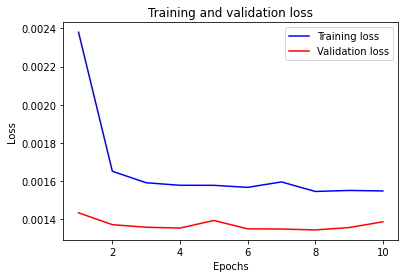

In [14]:
loss = model.history['loss']
val_loss = model.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b',label='Training loss')
plt.plot(epochs, val_loss, 'r' ,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
# 모델 저장
fsrcnn.save("./model/fsrcnn_1_hf.h5")

In [3]:
# 모델 불러오기
fsrcnn = tf.keras.models.load_model("./model/fsrcnn_1_hf4.h5")

Metal device set to: Apple M1


2022-04-22 11:36:22.180350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-22 11:36:22.180685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
## frame1655.png 로 테스트 해보자
# bicubic srcnn hr 순으로 비교해서 보여주자

# hr 불러오기 640 480
hr_folder = "./hr2/"
img2 = cv2.imread(hr_folder+"frame1655.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
hr = np.asarray(img2)

# 축소된 이미지 불러오기 320 240
bicubic_folder = "./hr2_down/"
img = cv2.imread(bicubic_folder+"frame1655.png")

# bicubic 보간하기
img3 = cv2.resize(img, dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
bicubic_sr = np.asarray(img3) # bicubic으로 640 480으로 키움

# fsrcnn 보간 직전
bicubic = np.asarray(img) # fsrcnn용으로 따로 내보냄

In [5]:
# srcnn_sr 불러오기
def apply_fsrcnn(x):
    sr = fsrcnn.predict(x[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    
    return np.array(sr[0].astype(np.uint8))

fsrcnn_sr = apply_fsrcnn(bicubic)
fsrcnn_sr = cv2.cvtColor(fsrcnn_sr, cv2.COLOR_BGR2RGB)

2022-04-22 11:36:23.151535: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-22 11:36:23.204405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [6]:
# clahe 적용하기
clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(8,8)) #CLAHE 생성

fsrcnn_c = cv2.cvtColor(fsrcnn_sr,cv2.COLOR_RGB2YUV) # clahe 적용

fsrcnn_c[:,:,0] = clahe.apply(fsrcnn_c[:,:,0])           #CLAHE 적용
fsrcnn_c = cv2.cvtColor(fsrcnn_c, cv2.COLOR_YUV2RGB)
sr_clahe = np.asarray(fsrcnn_c)

In [7]:
# crop 함수
def crop(img, z, x=100,y=100): #300
    return img[z[0]:(z[0]+x), z[1]:(z[1]+y), :]

Text(0.5, 1.0, 'hr')

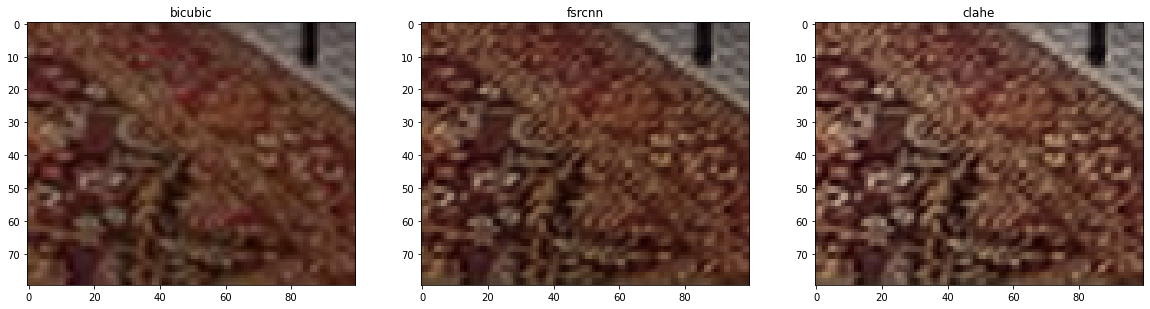

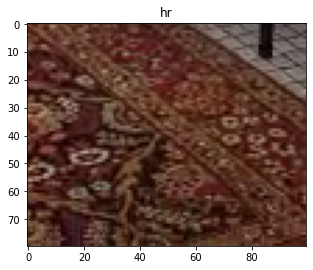

In [27]:
# 자세히 시각화하기 위해 3개 영역 잘라내기
# 아래는 잘라낸 부분의 좌상단 좌표 3개

z = (400,400) # 0 100

bicubic_crop = crop(bicubic_sr,z)
fsrcnn_crop = crop(fsrcnn_sr,z)
hr_crop = crop(hr,z)
c_crop = crop(sr_clahe,z)

## 이미지 비교
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(bicubic_crop)
plt.title("bicubic")

plt.subplot(1,3,2)
plt.imshow(fsrcnn_crop)
plt.title("fsrcnn")

plt.subplot(1,3,3)
plt.imshow(c_crop)
plt.title("clahe")

plt.figure(figsize=(5,5))
plt.imshow(hr_crop)
plt.title("hr")

In [40]:
## ssim 을 이용해서 어느정도 차이가 나는지 확인
from skimage.metrics import structural_similarity as ssim

In [41]:
hr_gray = cv2.cvtColor(hr, cv2.COLOR_BGR2GRAY)
bicubic_gray = cv2.cvtColor(bicubic_sr, cv2.COLOR_BGR2GRAY)
fsrcnn_gray = cv2.cvtColor(fsrcnn_sr, cv2.COLOR_BGR2GRAY)

# clahe
clahe_gray = cv2.cvtColor(sr_clahe, cv2.COLOR_BGR2GRAY)

In [42]:
(score, diff) = ssim(bicubic_gray, hr_gray, full=True)
diff = (diff * 255).astype("uint8")

(score2, diff2) = ssim(fsrcnn_gray, hr_gray, full=True)
diff2 = (diff2 * 255).astype("uint8")

# clahe
(score3, diff3) = ssim(clahe_gray, hr_gray, full=True)
diff3 = (diff3 * 255).astype("uint8")


print("bicubic_SSIM: {}".format(score))
print("fsrcnn_SSIM: {}".format(score2))
print("clahe_SSIM: {}".format(score3))

bicubic_SSIM: 0.8500861671914095
fsrcnn_SSIM: 0.8693016748592627
clahe_SSIM: 0.858678119216712


In [44]:
## psnr 을 이용해서 어느정도 차이가 나는지 확인
import math

def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 ) #MSE 구하는 코드
    print("MSE :", mse)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    print("PSNR :", 20 * math.log10(PIXEL_MAX / math.sqrt(mse))) #PSNR구하는 코드

    
print("bicubic vs hr")
dif = psnr(hr,bicubic_sr)

print("========================")

print("fsrcnn vs hr")
dif2 = psnr(hr,fsrcnn_sr)

print("========================")

print("clahe vs hr")
dif3 = psnr(hr,sr_clahe)

bicubic vs hr
MSE : 35.820194227430555
PSNR : 32.58952424478498
fsrcnn vs hr
MSE : 35.236905381944446
PSNR : 32.66082600587591
clahe vs hr
MSE : 65.75496961805555
PSNR : 29.951517794302568


In [ ]:
##### 640 480기반으로, bicubic:1280*960 vs fsrcnn:1280*960 비교해보자

In [70]:
# bicubic srcnn hr(따로 추출해야할듯) 순으로 비교해보자

# hr 불러오기 640 480
hr_folder = "./hr2/"
img = cv2.imread(hr_folder+"frame1655.png")

# bicubic
img2 = cv2.resize(img, dsize=(1280, 960), interpolation=cv2.INTER_CUBIC)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
bicubic_sr = np.asarray(img2)

In [71]:
# 모델 불러오기
fsrcnn = tf.keras.models.load_model("./model/fsrcnn_1_hf4.h5")

In [72]:
# srcnn_sr 불러오기
def apply_fsrcnn(x):
    sr = fsrcnn.predict(x[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    
    return np.array(sr[0].astype(np.uint8))

# fsrcnn을 거친 1280*960 이미지
fsrcnn_sr = apply_fsrcnn(img)
fsrcnn_sr = cv2.cvtColor(fsrcnn_sr, cv2.COLOR_BGR2RGB)

# crop 함수
def crop(img, z, x=300,y=300):
    return img[z[0]:(z[0]+x), z[1]:(z[1]+y), :]

2022-04-20 10:03:23.073854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'fsrcnn')

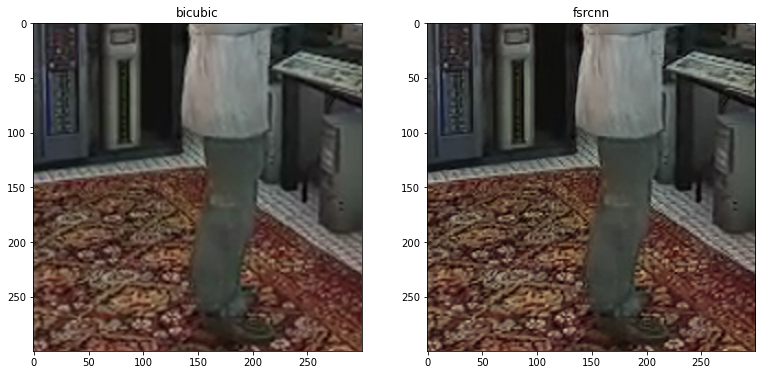

In [73]:
# 자세히 시각화하기 위해 3개 영역 잘라내기
# 아래는 잘라낸 부분의 좌상단 좌표 3개
z = (500,500)

bicubic_crop = crop(bicubic_sr,z)
fsrcnn_crop = crop(fsrcnn_sr,z)
#hr_crop = crop(hr,z)
## 이미지 비교
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(bicubic_crop)
plt.title("bicubic")

plt.subplot(1,3,2)
plt.imshow(fsrcnn_crop)
plt.title("fsrcnn")

#plt.subplot(1,3,3)
#plt.imshow(hr_crop)
#plt.title("hr")

In [ ]:
def apply_fsrcnn(x):
    sr = fsrcnn.predict(x[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    
    return np.array(sr[0].astype(np.uint8))

srcnn_sr = apply_fsrcnn(bicubic_sr)